# Salary Prediction based on Job Descriptions

The goal of this project is to predict salaries based on job descriptions. We will look at different factors and build a machine learning algorithm to predict the salary.

The model will help companies during hiring process in determining appropriate salaries for the candidates.

## Import libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xg
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import pickle

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Define data class for data processing

In [28]:
class Data:

    def __init__(self, train_features, train_target, test_features, target_col):
        ''' This class is used to for basic tasks such as data load, merge.
        This class accepts following 4 inputs:

        train_features - file path for features of training data
        train_target   - file path for target of training data
        test_features  - file path for features of testing data
        target_col     - name of target column'''

        self.train_features = train_features
        self.train_target = train_target
        self.test_features = test_features
        self.target_col = target_col
        self.process_data()

    def process_data(self):
        self._create_train_df()
        self._create_test_df()
        self._find_column_info()
        self._print_train_stats()
        self._verify_invalid_data(self.train_df, self.target_col)
        self._verify_duplicate_data()

    def _create_train_df(self):
        ''' This method prepares Train data'''
        train_features_df = self._load_csv(train_features)
        train_target_df = self._load_csv(train_target)
        self.train_df = self._merge_df(train_features_df, train_target_df)

    def _create_test_df(self):
        ''' This method prepares Test data'''
        self.test_df = self._load_csv(test_features)

    def _find_column_info(self):
        self.cat_cols = self._find_cat_cols(self.train_df)
        self.num_cols = self._find_num_cols(self.train_df)

    def _print_train_stats(self):
        print(' \n ^^^^^^^^^^^^^^ Training Dataframe Information ^^^^^^^^^^^^^^')
        self.print_stats(self.train_df)
        self._verify_nan(self.train_df)

    def _print_test_stats(self):
        print('\n ~~~~~~~~~~~~~~~ Test Dataframe Information ~~~~~~~~~~~~~~~~~~')
        self.print_stats(self.test_df)

    def _load_csv(self, file):
        ''' This method will load csv file into a dataframe'''
        return pd.read_csv(file)

    def _merge_df(self, df1, df2):
        ''' This method will merge 2 dataframes '''
        return pd.merge(df1, df2)

    def print_stats(self, df):
        print('-------------------------------------------------')
        print('Shape of the Dataframe - {}'.format(df.shape))
        print('-------------------------------------------------')
        print('\n Dataframe information:- \n')
        print('\n{}'.format(df.info()))
        print('-------------------------------------------------')
        print(' Statistics of Numerical data:- \n \n{}'.format(df.describe()))
        print('-------------------------------------------------')
        print(' Statistics of Categorical data:- \n \n{}'.format(df.describe(include='O')))

    def _verify_nan(self, df):
        '''This method verify the null values in a dataframe'''
        nan = np.sum(df.isna().sum())
        if nan == 0:
            print('\n\n :-- There are no Null values in the dataframe')
        else:
            print('Following columns have null values in dataframe\n\n{}'
                  .format(df.isnull().sum()))
            
    def _find_cat_cols(self, df):
        '''This method finds the categorical columns in a dataset'''
        self.cat_cols = df.select_dtypes(include=['O']).columns.tolist()
        print('-----------------------------------------')
        print('List of all Categorical columns in data:- {}'
              .format(self.cat_cols))
        print('-----------------------------------------')
        return self.cat_cols

    def _find_num_cols(self, df):
        '''This method finds the numerical columns in a dataset'''
        num_cols = df.select_dtypes(exclude=['O']).columns.tolist()
        print('List of all Numerical columns in data:- {}'
              .format(num_cols))
        print('-----------------------------------------')
        return num_cols

    def _verify_invalid_data(self, df, cols):
        ''' This function is used to find invalid values in a single or 
        mutiple columns of dataframe'''
        for col in [cols]:
            val_cnt = np.sum(df[col] <= 0)
            if val_cnt > 0:
                self.invalid_flag = True
                print('\n :-- There are {} invalid values are present in {} column'.format(val_cnt, col))

    def _verify_duplicate_data(self):
        '''This method will verify the duplicate data in a dataset'''
        print('\n :-- There are {} duplicate values are present in Train data'
              .format(self.train_df.duplicated().sum()))

## DrawPlot Class to visualize and gain insights from data

In [29]:
class DrawPlot:

    sns.set(style="whitegrid")

    def __init__(self, data):
        self.data = data
        self.train_df = data.train_df
        self.target_col = data.target_col
        self.cat_cols = data.cat_cols
        self.num_cols = data.num_cols
        self.cor_cols = ['jobType_mean', 'degree_mean', 'major_mean', 'industry_mean',
                         'companyId_mean', 'yearsExperience', 'milesFromMetropolis', 'salary']
        self.target_col = data.target_col
        self.process_eda()

    def process_eda(self):
        self._DistPlot()
        self._BoxPlot()
        self._Heatmap()

    def _DistPlot(self):
        '''This method is used to plot the histogram of all numeric variables in dataframe'''
        fig = plt.figure(figsize=(14, 14))
        for idx, col in enumerate(self.num_cols):
            fig.add_subplot(len(self.num_cols), len(self.num_cols), idx+1)
            sns.distplot(self.train_df[col], bins=20)
            plt.tight_layout()

    def _BoxPlot(self):
        '''This method is used to plot the Boxen plots of all Categorical variables in dataframe'''
        df = self.train_df.copy()
        fig = plt.figure(figsize=(14, 18))
        for idx, col in enumerate(self.cat_cols):
            if len(self.train_df[col].unique()) < 10:
                df[col +
                    '_mean'] = df.groupby(col)[self.target_col].transform('mean')
                fig.add_subplot(3, 2, idx+1)
                sns.boxenplot(x=col, y=self.target_col,
                              data=df.sort_values(col + '_mean'))
                plt.title('Comparison of salaries as per {}'.format(
                    col), fontsize=14)
                plt.tight_layout()
                plt.xticks(rotation=45)

    def _Heatmap(self):
        '''This method is used to plot the correlation between all numeric variables in dataframe'''
        df = self.train_df.copy()
        for col in self.cat_cols:
            if len(self.train_df[col].unique()) < 100:
                df[col +
                    '_mean'] = df.groupby(col)[self.target_col].transform('mean')
        fig = plt.figure(figsize=(12, 8))
        sns.heatmap(df[self.cor_cols].corr(), annot=True)
        plt.tight_layout()
        plt.title('Correlation Matrix', fontsize=16)
        plt.xticks(rotation=45)

## Feature Engineering Class

In [30]:
class FeatureEngg:
    '''This class will perform Feature Engineering such as Label Encoding, data cleaning, Impute missing  values etc.'''

    def __init__(self, data):
        self.data = data
        self.target = data.target_col
        self.invalid_flag = data.invalid_flag
        self.function = {'group_mean': 'mean', 'group_median': 'median',
                         'group_max': 'max', 'group_min': 'min', 'group_mad': 'mad'}
        self.cat_cols = ['jobType', 'degree', 'major', 'industry', 'companyId']
        self.impute_cols = ['jobType', 'industry', 'degree', 'major']
        self.id_col = 'jobId'
        self.labels = {}
        self._process_feature_engg()

    def _process_feature_engg(self):
        self._Feature_engg_train_df()
        self._Feature_engg_test_df()

    def _Feature_engg_train_df(self):
        if self.invalid_flag:
            self._clean_df()
        train_df = self._Label_Encoder(data.train_df, self.cat_cols)
        self.train_df = self.drop_cols(train_df, self.id_col)
        groupby_df = self._create_groupby(self.train_df, self.cat_cols)
        self.group_df = self._calc_group_stats(groupby_df, data.target_col)
        self.data.train_df = self._merge_groupby(
            self.train_df, self.group_df, self.cat_cols)

    def _Feature_engg_test_df(self):
        test_df = self._Label_Encoder(
            data.test_df, self.cat_cols, test_data=True)
        self.test_df = self.drop_cols(test_df, self.id_col)
        self.test_df = self._merge_groupby(
            self.test_df, self.group_df, self.cat_cols)
        self.data.test_df = self._impute_nan(self.test_df, self.function)

    def _Label_Encoder(self, df, cols, test_data=False):
        ''' This method creates label encoding for categorical data'''
        if not test_data:
            for col in cols:
                le = LabelEncoder()
                le.fit(df[col])
                self.labels[col] = le
                df[col] = le.transform(df[col])
        else:
            for col, le in self.labels.items():
                df[col] = le.transform(df[col])
        return df

    def drop_cols(self, df, cols):
        df = df.drop(columns=cols, axis=1)
        return df

    def _clean_df(self):
        print('In this dataframe some invalid values are present in salary column. we need to drop those  values \n')
        print('Shape of Dataframe before change:- {}'.format(data.train_df.shape))
        data.train_df = data.train_df[data.train_df['salary'] > 0]
        data.train_df.reset_index()
        print('Shape of Dataframe after dropping invalid rows:- {}'.format(
            data.train_df.shape, data.train_df.shape[0]))

    def _create_groupby(self, df, cols):
        df = df.groupby(cols)
        return df

    def _merge_groupby(self, df1, df2, keys):
        return pd.merge(df1, df2, on=keys, how='left')

    # Calculate group statistics of groups
    def _calc_group_stats(self, df, target):
        group_df = pd.DataFrame({'group_mean': df[target].mean()})
        group_df['group_median'] = df[target].median()
        group_df['group_max'] = df[target].max()
        group_df['group_min'] = df[target].min()
        group_df['group_mad'] = df[target].mad()
        group_df.reset_index(inplace=True)
        return group_df

    def _impute_nan(self, df, function):
        ''' There are some missing values present in test data in newly created features. From the 
        correlation plot,we knew that, correaltion of company id & salary is very minimum. So, we 
        have filled that missing values by taking group of other 4 columns. This imputer function 
        is specifc to this project'''
        for col, func in function.items():
            df[col] = df[col].fillna(df.groupby(
                self.impute_cols)[col].transform(func))
        return df

## Model Evaluation Class

In [32]:
class Eval_Model:
    '''This class will perform model evaluation based on Mean Square Error. 
    MSE -  It is the average squared difference between the estimated values and the actual value.
    In this class we have defined a baseline model, which considers group_mean as predicted value and we 
    are using the cross validation technique to calculate the MSE of 3 different models and then using 
    best model to calculate the Best model out of 3 (Linear Regreesion, Extra Tree Regression & 
    Light GBM Regression).'''

    def __init__(self, data, models):
        self.data = data
        self.models = models
        self.mean_mse = {}
        self.best_model = None
        self.prediction = None
        self.target_col = data.target_col
        self.base_target_df = data.train_df.group_mean
        self.target_df = data.train_df[data.target_col]
        self.feature_df = data.train_df.drop(data.target_col, axis=1)
        self.test_df = data.test_df
        self._process_models()

    def _process_models(self):
        self._baseline_model()
        self._cross_validate_model()
        self._best_model_process()

    def _baseline_model(self):
        '''For any baseline model, We can calculate the Mean of target, which is a good estimate.
        In this project, we had alreay calculated 'group_mean' of target, so, We have used the same for 
        baseline model'''
        self.mean_mse['Baseline_model'] = mean_squared_error(
            self.target_df, self.base_target_df)

    def _cross_validate_model(self, cv=3):
        print('\nCross Validation in progress.......')
        for model in self.models:
            scores = cross_val_score(
                model, self.feature_df, self.target_df, cv=cv, scoring='neg_mean_squared_error')
            self.mean_mse[model] = -1.0*np.mean(scores)

    def _best_model_process(self):
        '''This method will select the best model and perform fit on train data'''
        self.best_model = min(self.mean_mse, key=self.mean_mse.get)
        self._print_model_stats()
        print('\nFitting the Best Model.....')
        self.best_model.fit(self.feature_df, self.target_df)
        self._plot_feature_importance()
        print('\nPredicting on test data using the Best Model')
        self.test_df[self.target_col] = self.best_model.predict(self.test_df)

    def _print_model_stats(self):
        'This method will print the statistics of model'
        print('Models Statistics.......')
        for key, item in self.mean_mse.items():
            print('    \n Score of model {} :-'.format(key))
            print('\n          MSE - {}'.format(item))
        print('\n Best model is --------->\n\n {} :-'.format(self.best_model))
        print('\n          MSE - {}'.format(self.mean_mse[self.best_model]))

    def _plot_feature_importance(self):
        '''This method prints the feature importance used to train model'''
        print('\nPredicting Feature Importances')
        features = self.feature_df.columns.to_list()
        importances = self.best_model.feature_importances_
        indices = np.argsort(importances)
        plt.figure(figsize=(6, 6))
        plt.title('Feature Importances')
        plt.barh(range(len(indices)),
                 importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    @staticmethod
    def save_results(sub_file, df):
        print('\nSaving the predictions to a CSV file')
        df.to_csv(sub_file, index=False)

    @staticmethod
    def save_best_model(model_file, model):
        '''This model save the best model to a file'''
        print('\nSaving the Best Model to a file')
        pickle.dump(model, open(model_file, 'wb'))

    @staticmethod
    def tune_hyperparameter(estimator, param_grid, n_iter=5, scoring='neg_mean_absolute_error', cv=5, n_jobs=-2, refit=False):
        ''' This method is used to find the hyperparameters used in models'''
        rs_cv = RandomizedSearchCV(estimator=estimator, param_distribution=param_grid,
                                   n_iter=n_iter,
                                   cv=cv,
                                   n_jobs=n_jobs,
                                   refit=refit)
        rs_cv.fit(feature_df, target_df)
        return rs_cv.best_params_

## Define parameters to instantiate classes

In [33]:
# Defining parameters to instantiate and load Data
train_features = './data/raw/train_features.csv'
train_target = './data/raw/train_salaries.csv'
test_features = './data/raw/test_features.csv'
target_col = 'salary'

## Create data object and basic statistics

In [34]:
# create an instance of data object
data = Data(train_features, train_target, test_features, target_col)

-----------------------------------------
List of all Categorical columns in data:- ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']
-----------------------------------------
List of all Numerical columns in data:- ['yearsExperience', 'milesFromMetropolis', 'salary']
-----------------------------------------
 
 ^^^^^^^^^^^^^^ Training Dataframe Information ^^^^^^^^^^^^^^
-------------------------------------------------
Shape of the Dataframe - (1000000, 9)
-------------------------------------------------

 Dataframe information:- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
miles

## Create plot object

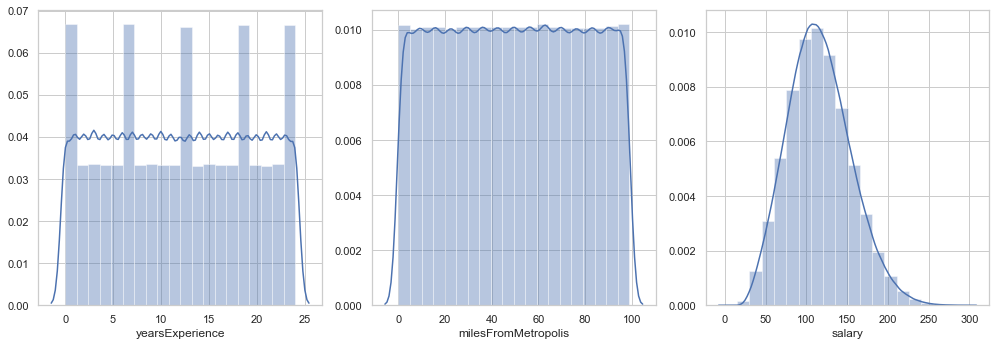

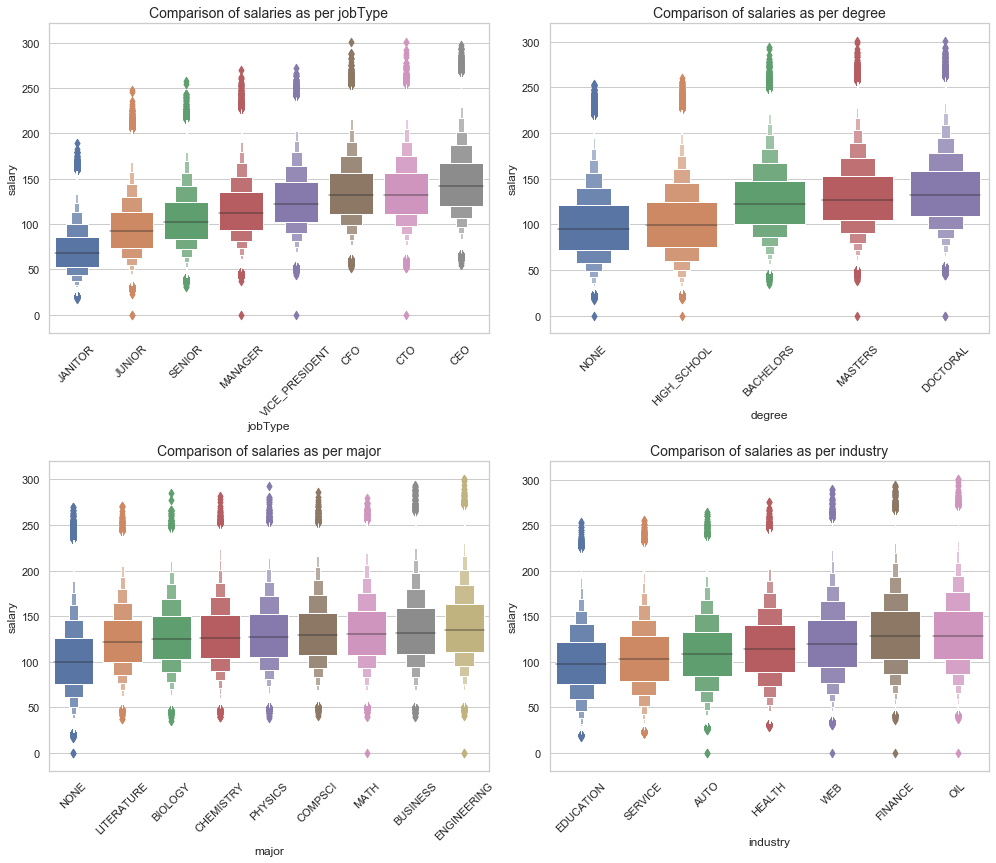

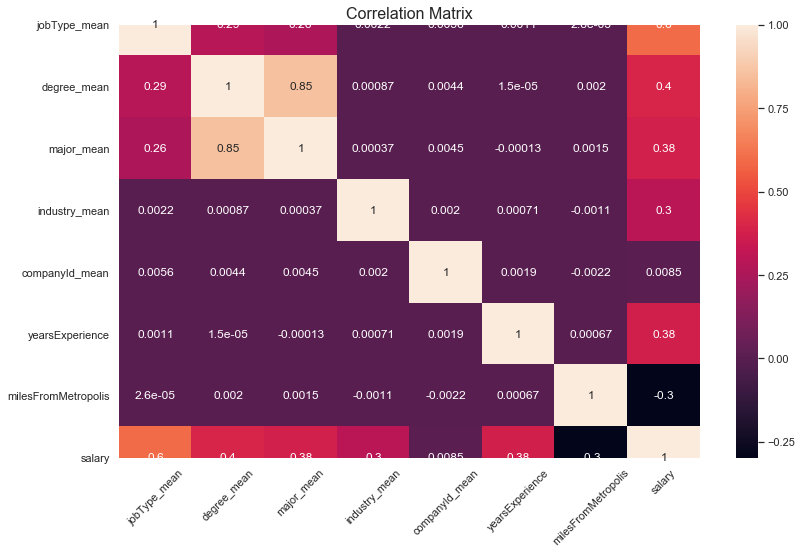

In [35]:
plot = DrawPlot(data)    
plot

## Create Features 

In [36]:
# here we will do some feature engineering
Feature_engineering = FeatureEngg(data)

In this dataframe some invalid values are present in salary column. we need to drop those  values 

Shape of Dataframe before change:- (1000000, 9)
Shape of Dataframe after dropping invalid rows:- (999995, 9)


## Create model object


Cross Validation in progress.......
Models Statistics.......
    
 Score of model Baseline_model :-

          MSE - 644.2563251928312
    
 Score of model LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) :-

          MSE - 358.14842087856647
    
 Score of model ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=12, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=40, n_jobs=None, oob_score=False,
                    random_state=42, verbose=0, warm_start=False) :-

          MSE - 316.8683588258557
    
 Score of model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0.4, learning_rate=0.1, max_delta_step=0,
             max

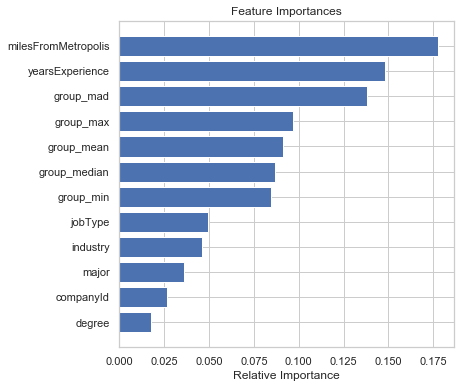


Predicting on test data using the Best Model


In [37]:
# Here we have defined 3 different algorithms i.e Linear Regression, ExtraTreeRegressor and Extreme Gradient Boosting Regressor
# ExtraTreeRegressor and XGBRegressor are Ensemble methods and we have tuned their hyperparameters.

lr = LinearRegression()
etr = ExtraTreesRegressor(n_estimators=40, max_depth=12,
                          min_samples_split=2,  min_samples_leaf=2, random_state=42)
xgb = xg.XGBRegressor(max_depth=8,min_child_weight=6,gamma=0.4)

models = [lr, etr, xgb]

model = Eval_Model(data, models)

## Saving the results

In [39]:
# Saving the submission file using the Best model
sub_file = './submission/Salary_Prediction_Submission.csv'
model.save_results(sub_file,model.test_df)


Saving the predictions to a CSV file


In [42]:
# Saving the Best model to a file.
model_file = './models/Salary_Prediction_Best_Model.sav'
model.save_best_model(model_file, model.best_model)


Saving the Best Model to a file
